In [247]:
import random
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision import transforms as T
from torch.optim.lr_scheduler import StepLR

In [248]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        # get resnet model
        self.resnet = torchvision.models.resnet18(weights=None)

        # over-write the first conv layer to be able to read MNIST images
        # as resnet18 reads (3,x,x) where 3 is RGB channels
        # whereas MNIST has (1,x,x) where 1 is a gray-scale channel
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.fc_in_features = self.resnet.fc.in_features
        
        # remove the last layer of resnet18 (linear layer which is before avgpool layer)
        self.resnet = torch.nn.Sequential(*(list(self.resnet.children())[:-1]))

        # add linear layers to compare between the features of the two images
        self.fc = nn.Sequential(
            nn.Linear(self.fc_in_features * 2, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 1),
        )

        self.sigmoid = nn.Sigmoid()

        # initialize the weights
        self.resnet.apply(self.init_weights)
        self.fc.apply(self.init_weights)
        
    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)

    def forward_once(self, x):
        output = self.resnet(x)
        output = output.view(output.size()[0], -1)
        return output

    def forward(self, input1, input2):
        # get two images' features
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)

        # concatenate both images' features
        output = torch.cat((output1, output2), 1)

        # pass the concatenation to the linear layers
        output = self.fc(output)

        # pass the out of the linear layers to sigmoid layer
        output = self.sigmoid(output)
        
        return output

In [249]:
class APP_MATCHER(Dataset):
    def __init__(self, root, train, download=False):
        super(APP_MATCHER, self).__init__()

        # get MNIST dataset
        self.dataset = datasets.MNIST(root, train=train, download=download)
        
        # as `self.dataset.data`'s shape is (Nx28x28), where N is the number of
        # examples in MNIST dataset, a single example has the dimensions of
        # (28x28) for (WxH), where W and H are the width and the height of the image. 
        # However, every example should have (CxWxH) dimensions where C is the number 
        # of channels to be passed to the network. As MNIST contains gray-scale images, 
        # we add an additional dimension to corresponds to the number of channels.
        self.data = self.dataset.data.unsqueeze(1).clone()

        self.group_examples()

    def group_examples(self):
        """
            To ease the accessibility of data based on the class, we will use `group_examples` to group 
            examples based on class. 
            
            Every key in `grouped_examples` corresponds to a class in MNIST dataset. For every key in 
            `grouped_examples`, every value will conform to all of the indices for the MNIST 
            dataset examples that correspond to that key.
        """

        # get the targets from MNIST dataset
        np_arr = np.array(self.dataset.targets.clone())
        
        # group examples based on class
        self.grouped_examples = {}
        for i in range(0,10):
            self.grouped_examples[i] = np.where((np_arr==i))[0]
    
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, index):
        """
            For every example, we will select two images. There are two cases, 
            positive and negative examples. For positive examples, we will have two 
            images from the same class. For negative examples, we will have two images 
            from different classes.

            Given an index, if the index is even, we will pick the second image from the same class, 
            but it won't be the same image we chose for the first class. This is used to ensure the positive
            example isn't trivial as the network would easily distinguish the similarity between same images. However,
            if the network were given two different images from the same class, the network will need to learn 
            the similarity between two different images representing the same class. If the index is odd, we will 
            pick the second image from a different class than the first image.
        """

        # pick some random class for the first image
        selected_class = random.randint(0, 9)

        # pick a random index for the first image in the grouped indices based of the label
        # of the class
        random_index_1 = random.randint(0, self.grouped_examples[selected_class].shape[0]-1)
        
        # pick the index to get the first image
        index_1 = self.grouped_examples[selected_class][random_index_1]

        # get the first image
        image_1 = self.data[index_1].clone().float()

        # same class
        if index % 2 == 0:
            # pick a random index for the second image
            random_index_2 = random.randint(0, self.grouped_examples[selected_class].shape[0]-1)
            
            # ensure that the index of the second image isn't the same as the first image
            while random_index_2 == random_index_1:
                random_index_2 = random.randint(0, self.grouped_examples[selected_class].shape[0]-1)
            
            # pick the index to get the second image
            index_2 = self.grouped_examples[selected_class][random_index_2]

            # get the second image
            image_2 = self.data[index_2].clone().float()

            # set the label for this example to be positive (1)
            target = torch.tensor(1, dtype=torch.float)
        
        # different class
        else:
            # pick a random class
            other_selected_class = random.randint(0, 9)

            # ensure that the class of the second image isn't the same as the first image
            while other_selected_class == selected_class:
                other_selected_class = random.randint(0, 9)

            
            # pick a random index for the second image in the grouped indices based of the label
            # of the class
            random_index_2 = random.randint(0, self.grouped_examples[other_selected_class].shape[0]-1)

            # pick the index to get the second image
            index_2 = self.grouped_examples[other_selected_class][random_index_2]

            # get the second image
            image_2 = self.data[index_2].clone().float()

            # set the label for this example to be negative (0)
            target = torch.tensor(0, dtype=torch.float)

        return image_1, image_2, target

In [250]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()

    for batch_idx, (images_1, images_2, targets) in enumerate(train_loader):
        images_1, images_2, targets = images_1.to(device), images_2.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(images_1, images_2).squeeze()
        loss = nn.BCELoss()(outputs, targets)
        loss.backward()
        optimizer.step()
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(images_1), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [251]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for (images_1, images_2, targets) in test_loader:
            images_1, images_2, targets = images_1.to(device), images_2.to(device), targets.to(device)
            outputs = model(images_1, images_2).squeeze()
            test_loss += nn.BCELoss()(outputs, targets).sum().item()  # sum up batch loss
            pred = torch.where(outputs > 0.5, 1, 0)  # get the index of the max log-probability
            correct += pred.eq(targets.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    # for the 1st epoch, the average loss is 0.0001 and the accuracy 97-98%
    # using default settings. After completing the 10th epoch, the average
    # loss is 0.0000 and the accuracy 99.5-100% using default settings.
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [252]:
torch.manual_seed(1)

device = "cuda" if torch.cuda.is_available() else "cpu"

train_dataset = APP_MATCHER('../data', train=True, download=True)
test_dataset = APP_MATCHER('../data', train=False)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=1, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1000, shuffle=True, num_workers=1, pin_memory=True)

model = SiameseNetwork().to(device)
optimizer = optim.Adadelta(model.parameters(), lr=1.0)
scheduler = StepLR(optimizer, step_size=1, gamma=0.7)

for epoch in range(1, 14 + 1):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)
    scheduler.step()

torch.save(model.state_dict(), "siamese_network.pt")

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.846426
Train Epoch: 1 [640/60000 (1%)]	Loss: 0.758750
Train Epoch: 1 [1280/60000 (2%)]	Loss: 0.618676
Train Epoch: 1 [1920/60000 (3%)]	Loss: 0.492990
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.561057
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.433822
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.406717
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.446250
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.441644
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.345143
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.349309
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.243017
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.446702
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.471102
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.308642
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.322429
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.181834
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.165823
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.350570
Train Epoch: 1 [12160/60000 (20%)]	Loss: 0.369339
Train Epoch: 1 [12800/60000 (

In [253]:
# Show images
def show_images(image): 
    plt.imshow(torchvision.transforms.ToPILImage()(image[0]), cmap='gray')
    plt.axis('off')
    plt.show()

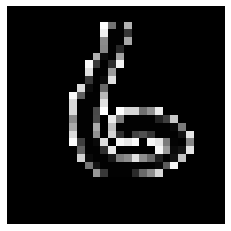

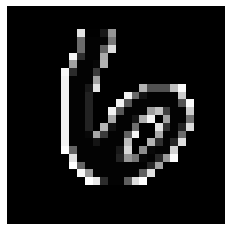

Target: 1
Output: 0.9999995231628418
Loss of Target & Output: 4.768372718899627e-07
Correct: 1


In [255]:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True, num_workers=1, pin_memory=True)

model.eval()
test_loss = 0
correct = 0

with torch.no_grad():
    for (images_1, images_2, targets) in test_loader:
        show_images(images_1)
        show_images(images_2)
        images_1, images_2, targets = images_1.to(device), images_2.to(device), targets.to(device)
        outputs = model(images_1, images_2).squeeze(0)
        test_loss += nn.BCELoss()(outputs, targets).sum().item()  # sum up batch loss
        pred = torch.where(outputs > 0.5, 1, 0)  # get the index of the max log-probability
        correct += pred.eq(targets.view_as(pred)).sum().item()
        break

print("Target: " + str(int(targets.item())))
print("Output: " + str(outputs.item()))     
print("Loss of Target & Output: " + str(test_loss))
print("Correct: " + str(correct))